In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

In [2]:
df = pd.read_csv('../data.csv')

### User wait times

In [4]:
# If the wait_times have been saved, load them
if os.path.isfile('wait_times.npy'):
    print('Loading wait times from file...')
    wait_times = np.load('./wait_times.npy')
    print('Done.')
else:
    print('Calculating wait times...')
    # Create an array of zeros, each zero corresponds to one unique user.
    last_place_time = np.zeros(df['user'].nunique())

    # Create an empty array to store the wait times.
    wait_times = np.zeros(df.shape[0], dtype=int)

    # Iterate through the rows of the dataframe using itertuples to preserve the dtype of the columns. This is important because we use the user column as an index, which must be an integer.
    # For each row, check when the user last placed a pixel by accessing the last_place_time array at the index (corresponding to the user id).
    # Calculate the difference between the row's time and the last place time and write it into the wait_times array. This is faster than writing it into the dataframe.
    # If the last place time is 0, then the user has not placed a pixel yet. In this case, the wait time is -1.
    # Lastly, update the last place time array at the index (corresponding to the user id) with the row's time.
    for i, row in enumerate(tqdm(df.itertuples(), total=df.shape[0])):
        if last_place_time[row.user] == 0:
            wait_times[i] = -1
        else:
            wait_times[i] = row.unix - last_place_time[row.user]

        last_place_time[row.user] = row.unix
    
    # Save the wait times to a file.
    print('Saving wait times to file...')
    np.save('./wait_times.npy', wait_times)
    print('Done.')

Loading wait times from file...
Done.


In [5]:
# Filter out the wait times that are -1.
valid_wait_times = wait_times[wait_times > 0]

# Determine the colors that users have been waiting for.
valid_wait_time_colors = np.array(df['color'][wait_times > 0])

In [6]:
# Compute color independent histograms
coarse_hist = np.histogram(np.log(valid_wait_times + 1e-6), bins=np.linspace(np.log(5 * 60 * 1e3), np.log(np.max(valid_wait_times)), 4000+1))
medium_hist = np.histogram(np.log(valid_wait_times + 1e-6), bins=np.linspace(np.log(5 * 60 * 1e3), np.log(45 * 60 * 1e3), 4000+1))
fine_hist = np.histogram(np.log(valid_wait_times + 1e-6), bins=np.linspace(np.log(4.95 * 60 * 1e3), np.log(5.55 * 60 * 1e3), 1500+1))

### Unusual wait times

In [7]:
# Slide a window of size N over the histogram and calculate the maximum value in each window.
# Store the global position of the maxima in a list.

N = 25

maxima_positions = []
local_relative_maxima_values = []
for i in range(0, len(coarse_hist[0]) - N):
    maxima_positions.append(np.argmax(coarse_hist[0][i:i+N])+i)
    # Via significance
    # deviation_from_local_mean = np.abs(np.mean(hist[0][i:i+N]) - hist[0][i+N//2])
    # local_relative_maxima_values.append(deviation_from_local_mean / np.std(hist[0][i:i+N]))
    # Via relative value
    local_relative_maxima_values.append(np.max(coarse_hist[0][i:i+N]) / np.mean(coarse_hist[0][i:i+N]))

# Compute the likelihood of a maximum position to be a local maximum by counting the frequency of each local maximum position weighted by the local relative maximum value and the uncertainty of the histogram at that position.
# (Why is this not the inverse of the uncertainty? Is it because the relative error is sqrt(N)/N = 1/sqrt(N) and its inverse is sqrt(N)?)
position_is_local_maximum_likelihood = np.bincount(maxima_positions, weights=local_relative_maxima_values*np.sqrt(coarse_hist[0][maxima_positions]), minlength=len(coarse_hist[0]))

# Filter out the positions that are not local maxima.
# Likely local maxima have likelihood > mean(likelihood) + sig*std(likelihood)
sig=7
likely_local_maxima = np.where(position_is_local_maximum_likelihood > np.mean(position_is_local_maximum_likelihood) + sig*np.std(position_is_local_maximum_likelihood))[0]

# Calculate the corresponding time of the likely local maxima.
likely_local_maxima_raw = coarse_hist[1][likely_local_maxima]

# Convert the times into minutes
likely_local_maxima_times = np.exp(likely_local_maxima_raw) / 1e3 / 60


f'Founnd {len(likely_local_maxima)} likely local maxima.'

'Founnd 12 likely local maxima.'

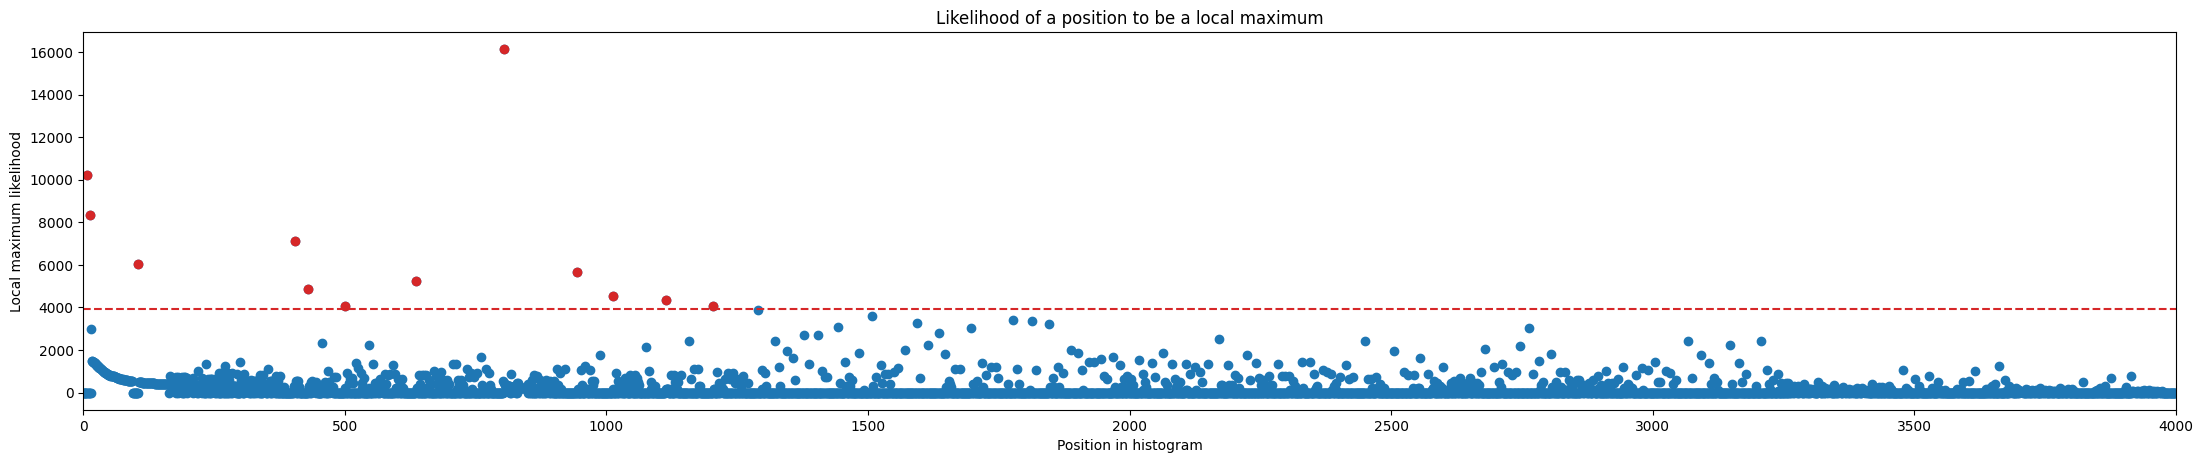

In [8]:
fig, ax = plt.subplots(figsize=(27, 5), dpi=100)
ax.scatter(np.arange(len(position_is_local_maximum_likelihood)), position_is_local_maximum_likelihood)
# Mark likely local maxima in red
ax.scatter(likely_local_maxima, position_is_local_maximum_likelihood[likely_local_maxima], color='tab:red')
# Mark the threshold with a dotted line
ax.axhline(np.mean(position_is_local_maximum_likelihood) + sig*np.std(position_is_local_maximum_likelihood), color='tab:red', linestyle='--')
ax.set_xlim(0, len(position_is_local_maximum_likelihood))
ax.set_xlabel('Position in histogram')
ax.set_ylabel('Local maximum likelihood')
ax.set_title('Likelihood of a position to be a local maximum');

### Wait time distribution

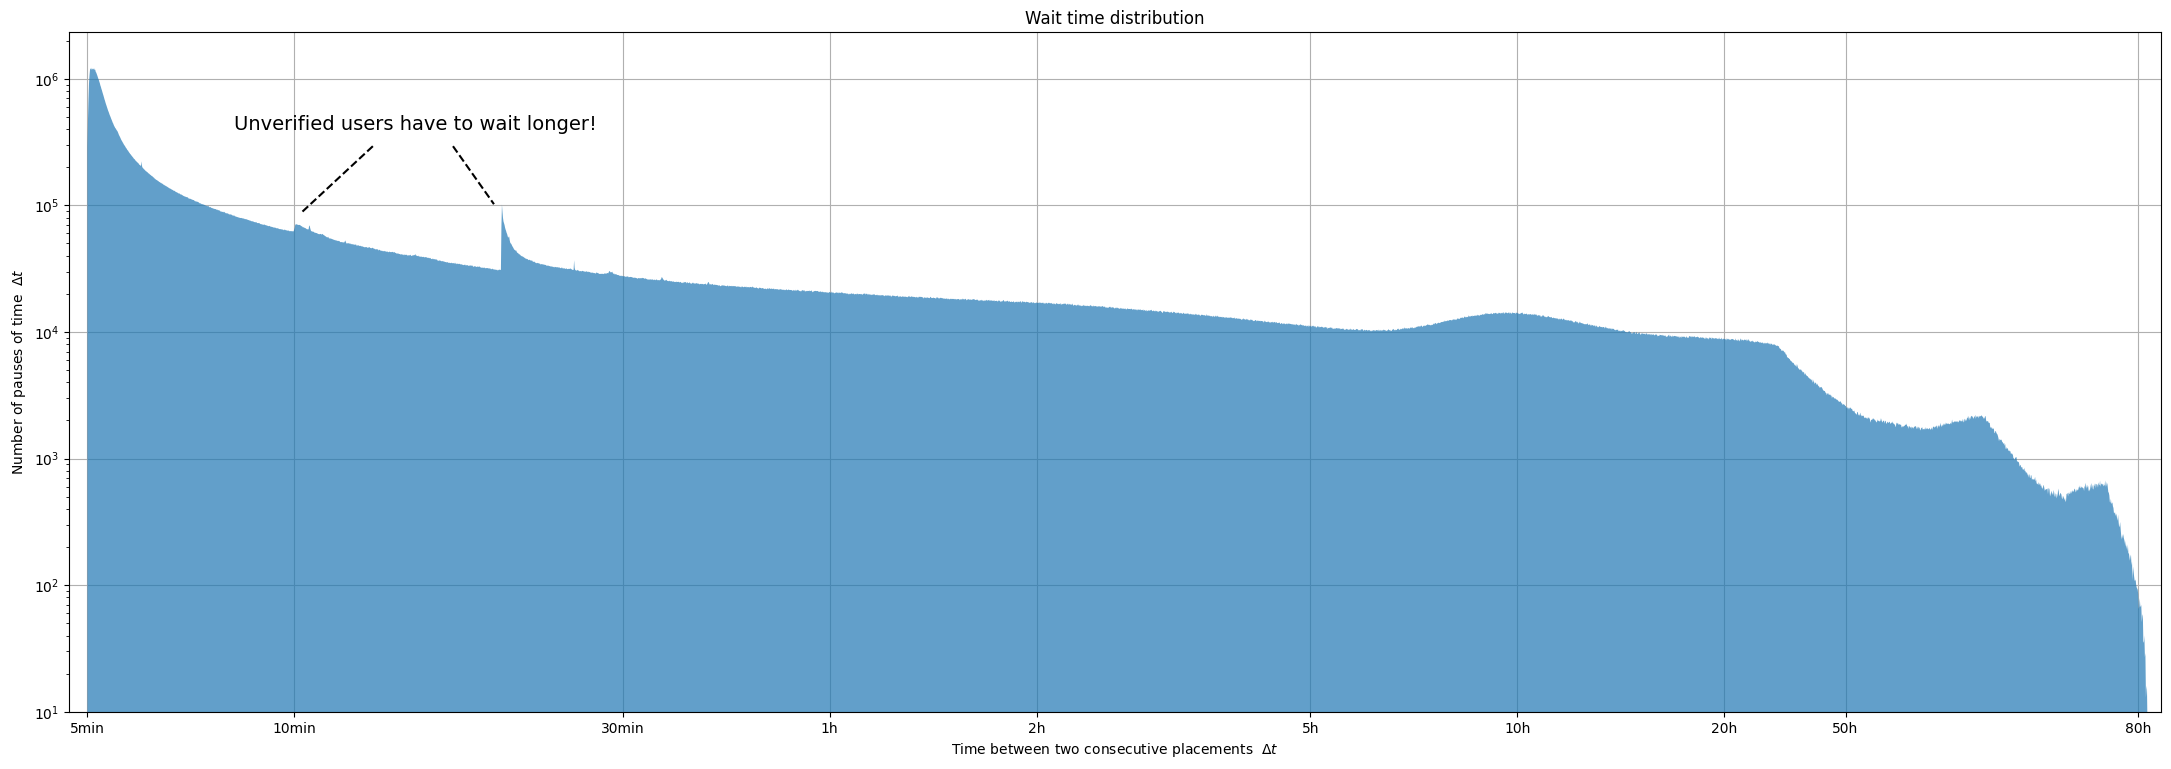

In [9]:
fig, ax = plt.subplots(figsize=(27, 9), dpi=100)

# Draw the histogram
ax.fill_between(coarse_hist[1][:-1], 0, coarse_hist[0], color='tab:blue', alpha=0.7, zorder=2, edgecolor='none')

ax.set_xlabel(r'Time between two consecutive placements  $\Delta t$')
ax.set_ylabel(r'Number of pauses of time  $\Delta t$')
ax.set_title(f'Wait time distribution')
ax.set_yscale('log')

# Create xticks for t = 5min, 10min, 30min, 1h, 2h, 5h, 10h, 20h, 50h, 80h
factor = 60 * 1e3
xticks = np.log([factor * i for i in [5, 10, 30, 60, 120, 300, 600, 1200, 1800, 80*60]])
ax.set_xticks(xticks)

# Create labels for the xticks
xticklabels = ['5min', '10min', '30min', '1h', '2h', '5h', '10h', '20h', '50h', '80h']
ax.set_xticklabels(xticklabels);

ax.set_xlim(xticks[0]*0.995, np.log(83*60*factor)*1.002);
ax.set_ylim(1e1, None)

# https://www.reddit.com/r/place/comments/tu6ak6/why_is_the_wait_time_20_minutes_now/
# Show a text "Unverified users have to wait longer." at about t = 15min in the plot
# Draw two lines from the center of the text to:
# 1. The top of the bar corresponding to 10min
# 2. The bottom of the bar corresponding to 20min
text_location_height = np.max(coarse_hist[0]) * 0.3
ax.text(np.log(15*factor), text_location_height, 'Unverified users have to wait longer!', ha='center', va='bottom', fontsize=14)
hist_edge_index_10min = np.argmin(np.abs(coarse_hist[1][:-1] - np.log(10*factor)))
hist_edge_index_20min = np.argmin(np.abs(coarse_hist[1][:-1] - np.log(20*factor)))
ax.plot([np.log(13*factor), np.log(10.2*factor)], [text_location_height*0.8, coarse_hist[0][hist_edge_index_10min]*1.3], 'k--')
ax.plot([np.log(17*factor), np.log(19.5*factor)], [text_location_height*0.8, coarse_hist[0][hist_edge_index_20min]*1.5], 'k--');

ax.grid(axis='both', zorder=1)

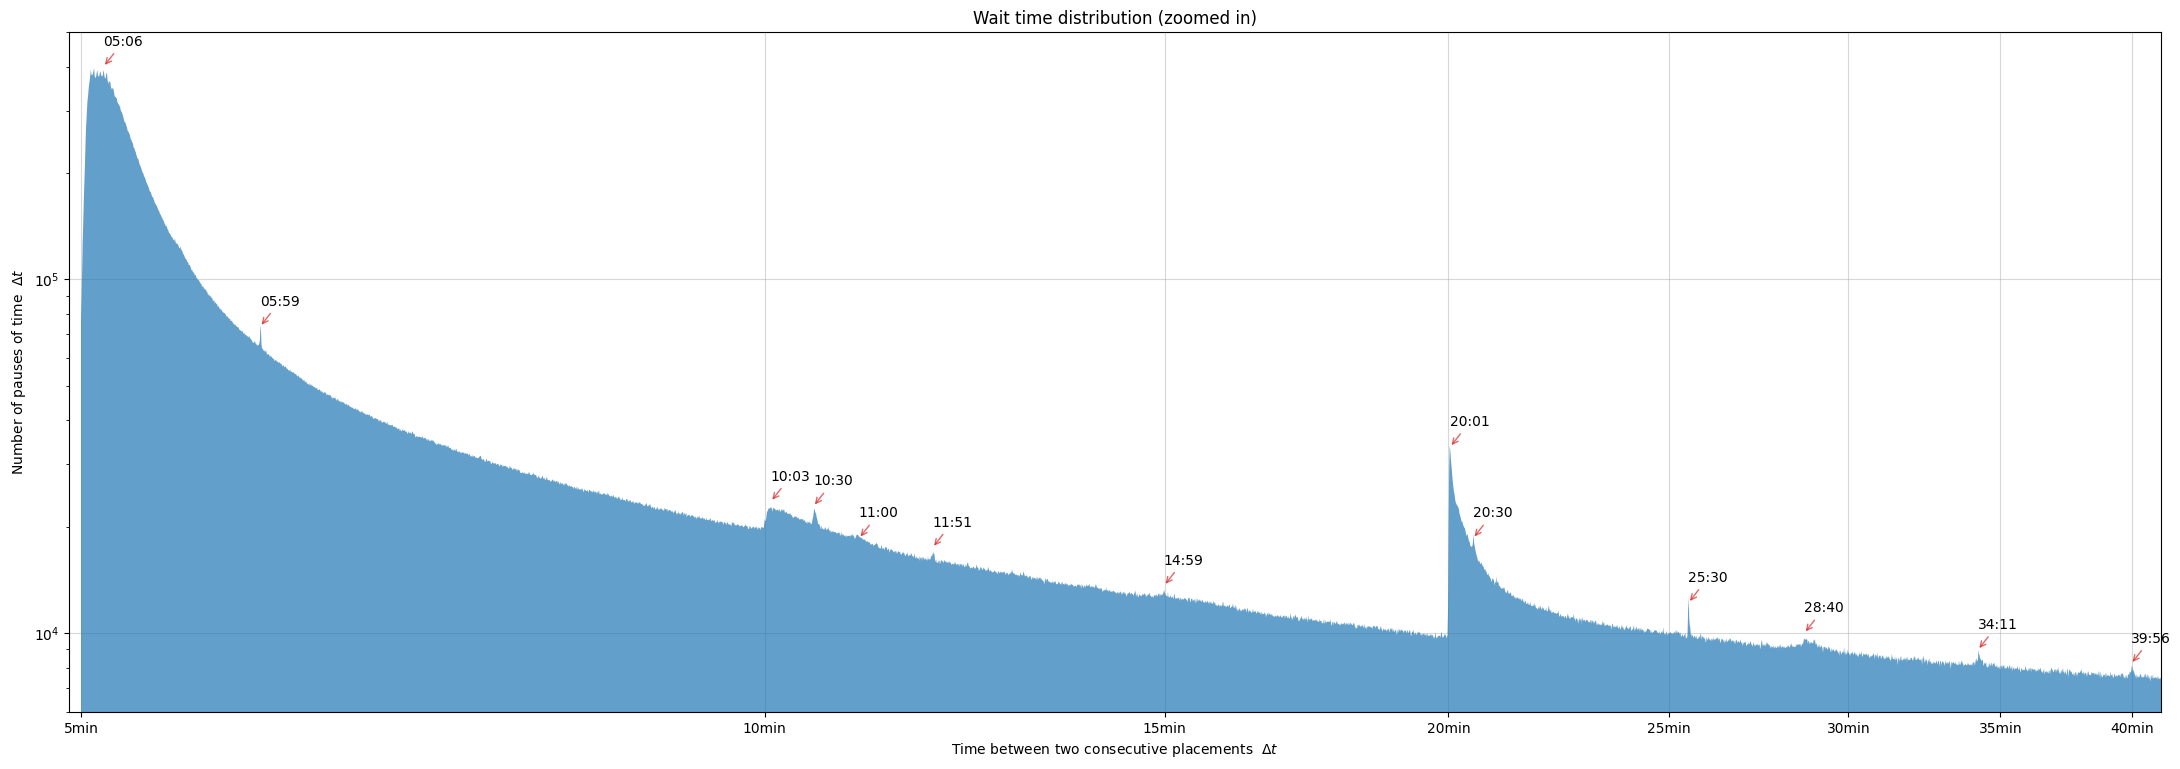

In [10]:
# Zoom in on the range from t = 5min to t = 40min
fig, ax = plt.subplots(figsize=(27, 9), dpi=100)

# Draw the histogram
ax.fill_between(medium_hist[1][:-1], 0, medium_hist[0], color='tab:blue', alpha=0.7, zorder=2, edgecolor='none')
# ax.bar(hist[1][:-1], hist[0], color='tab:blue', alpha=0.7, zorder=2, edgecolor='none', width=hist[1][1] - hist[1][0])

scale_factor = 0.33

# Mark the likely local maxima with arrows above the histogram
for i in range(1, len(likely_local_maxima)):
    # Convert the likely_local_maxima_times into mm:ss format
    ax.annotate(
        f'{int(likely_local_maxima_times[i]):02d}:{int((likely_local_maxima_times[i] * 60)%60):02d}',
        xy=(likely_local_maxima_raw[i], scale_factor*coarse_hist[0][likely_local_maxima[i]]),
        xytext=(likely_local_maxima_raw[i], scale_factor*coarse_hist[0][likely_local_maxima[i]]*1.15),
        arrowprops=dict(arrowstyle='->', color='tab:red', linewidth=1, alpha=0.7))

another_likely_local_maximum_time = 20.5
another_likely_local_maximum_raw = np.log(another_likely_local_maximum_time * 1e3 * 60)
ax.annotate(
    f'{int(another_likely_local_maximum_time):02d}:{int((another_likely_local_maximum_time * 60)%60):02d}',
    xy=(another_likely_local_maximum_raw, 1.85e4),
    xytext=(another_likely_local_maximum_raw, 1.85e4*1.15),
    arrowprops=dict(arrowstyle='->', color='tab:red', linewidth=1, alpha=0.7))
    
another_likely_local_maximum_time = 11
another_likely_local_maximum_raw = np.log(another_likely_local_maximum_time * 1e3 * 60)
ax.annotate(
    f'{int(another_likely_local_maximum_time):02d}:{int((another_likely_local_maximum_time * 60)%60):02d}',
    xy=(another_likely_local_maximum_raw, 1.85e4),
    xytext=(another_likely_local_maximum_raw, 1.85e4*1.15),
    arrowprops=dict(arrowstyle='->', color='tab:red', linewidth=1, alpha=0.7))

ax.set_xlabel(r'Time between two consecutive placements  $\Delta t$')
ax.set_ylabel(r'Number of pauses of time  $\Delta t$')
ax.set_title(f'Wait time distribution (zoomed in)')
ax.set_yscale('log')

# Create xticks for t = 5min, 10min, 15min, 20min, 25min, 30min, 35min, 40min
factor = 60 * 1e3
xticks = np.log([factor * i for i in [5, 10, 15, 20, 25, 30, 35, 40]])
ax.set_xticks(xticks)

# Create labels for the xticks
xticklabels = ['5min', '10min', '15min', '20min', '25min', '30min', '35min', '40min']
ax.set_xticklabels(xticklabels);

# Zoom in on the range from t = 5min to t = 40min
ax.set_xlim(xticks[0]*0.999, np.log(40*factor)*1.002);
ax.set_ylim(6e3, 5e5)

ax.grid(axis='both', zorder=1, alpha=0.5)

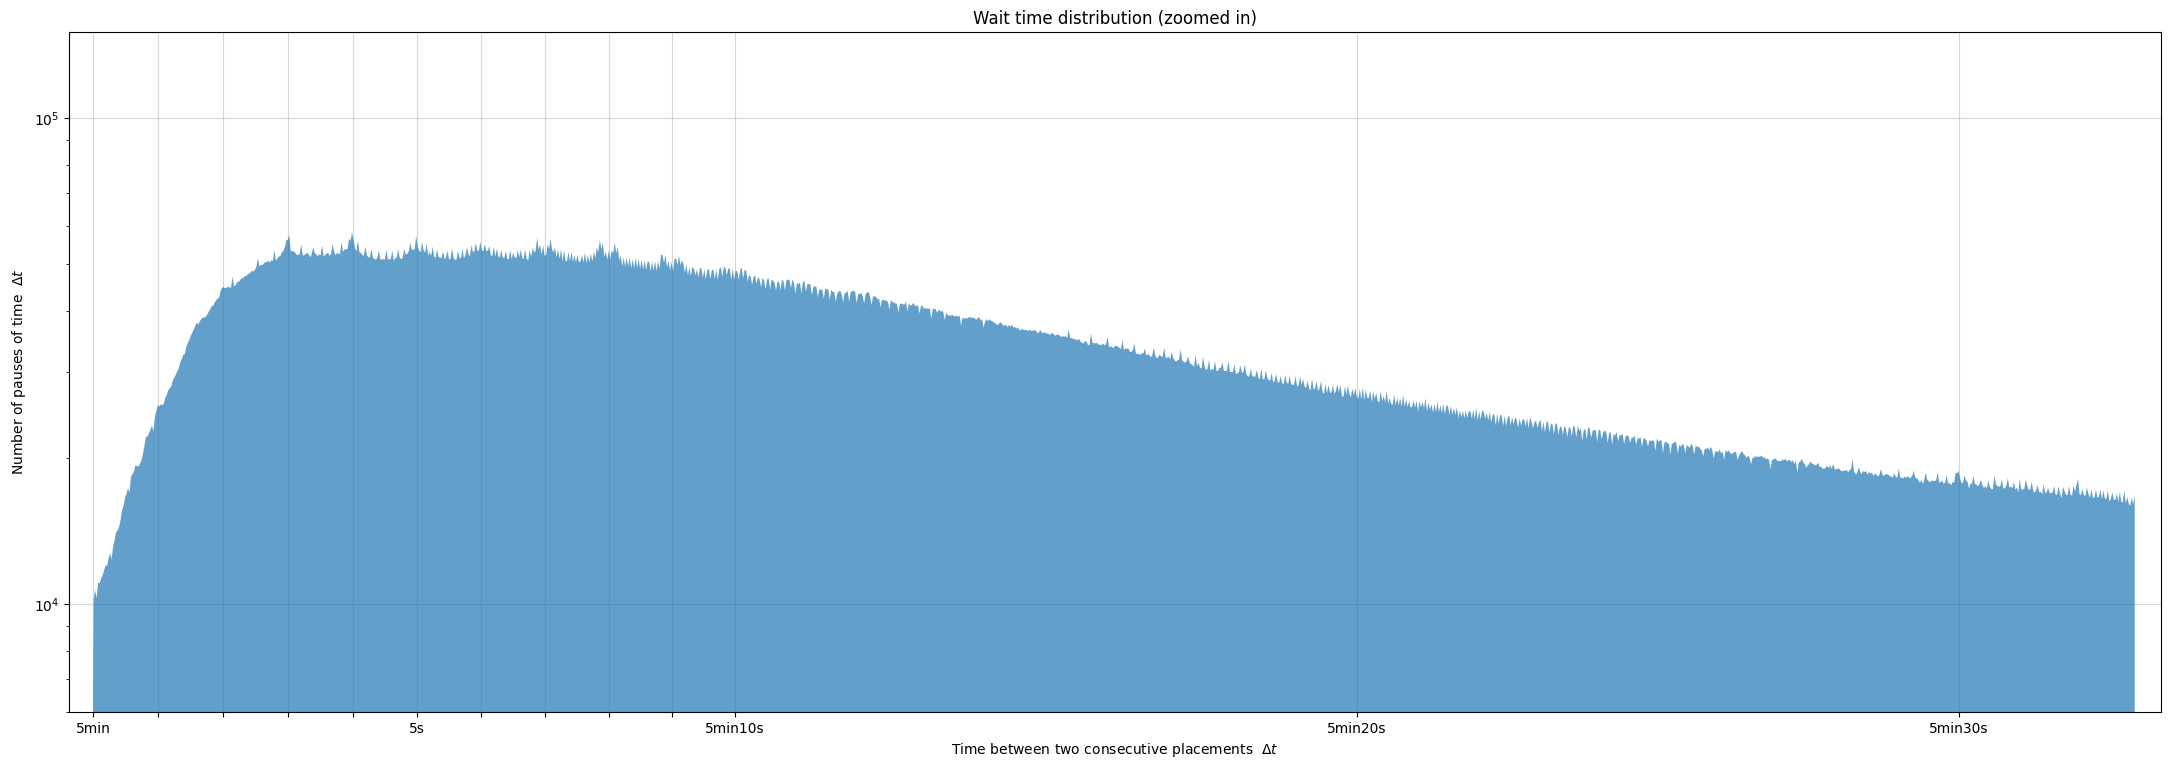

In [11]:
# Zoom in on the range from t = 5min to t = 40min
fig, ax = plt.subplots(figsize=(27, 9), dpi=100)

# Draw the histogram
ax.fill_between(fine_hist[1][:-1], 0, fine_hist[0], color='tab:blue', alpha=0.7, zorder=2, edgecolor='none')
# ax.bar(hist[1][:-1], hist[0], color='tab:blue', alpha=0.7, zorder=2, edgecolor='none', width=hist[1][1] - hist[1][0])

ax.set_xlabel(r'Time between two consecutive placements  $\Delta t$')
ax.set_ylabel(r'Number of pauses of time  $\Delta t$')
ax.set_title(f'Wait time distribution (zoomed in)')
ax.set_yscale('log')

# Create xticks for t = 5min, 5min01s, 5min02s, 5min03s, 5min04s, 5min05s, 5min06s, 5min07s, 5min08s, 5min09s, 5min10s, 5min20s, 5min30s
factor = 60 * 1e3
xticks = np.log([factor * i for i in [5, 5+1/60, 5+2/60, 5+3/60, 5+4/60, 5+5/60, 5+6/60, 5+7/60, 5+8/60, 5+9/60, 5+10/60, 5+20/60, 5+30/60]])
ax.set_xticks(xticks)

# Create labels for the xticks
xticklabels = ['5min', '', '', '', '', '5s', '', '', '', '', '5min10s', '5min20s', '5min30s']
ax.set_xticklabels(xticklabels);

# Zoom in on the range from t = 5min to t = 40min
ax.set_xlim(np.log(5*factor)*0.9999, np.log(5.55*factor)*1.0001);
ax.set_ylim(6e3, 1.5e5)

ax.grid(axis='both', zorder=1, alpha=0.5)

### Weighted wait time distribution

In [12]:
# Weight the histogram by the wait time.
# This is done by multiplying the histogram bin with the wait time.
# Units are milliseconds

weighted_hist = coarse_hist[0] * (np.exp(coarse_hist[1][1:]) - np.exp(coarse_hist[1][:-1]))/2

# Uncertainty of the weighted histogram, neglecting the bin width.
weighted_hist_error = np.sqrt(coarse_hist[0]) * (np.exp(coarse_hist[1][1:]) - np.exp(coarse_hist[1][:-1]))/2

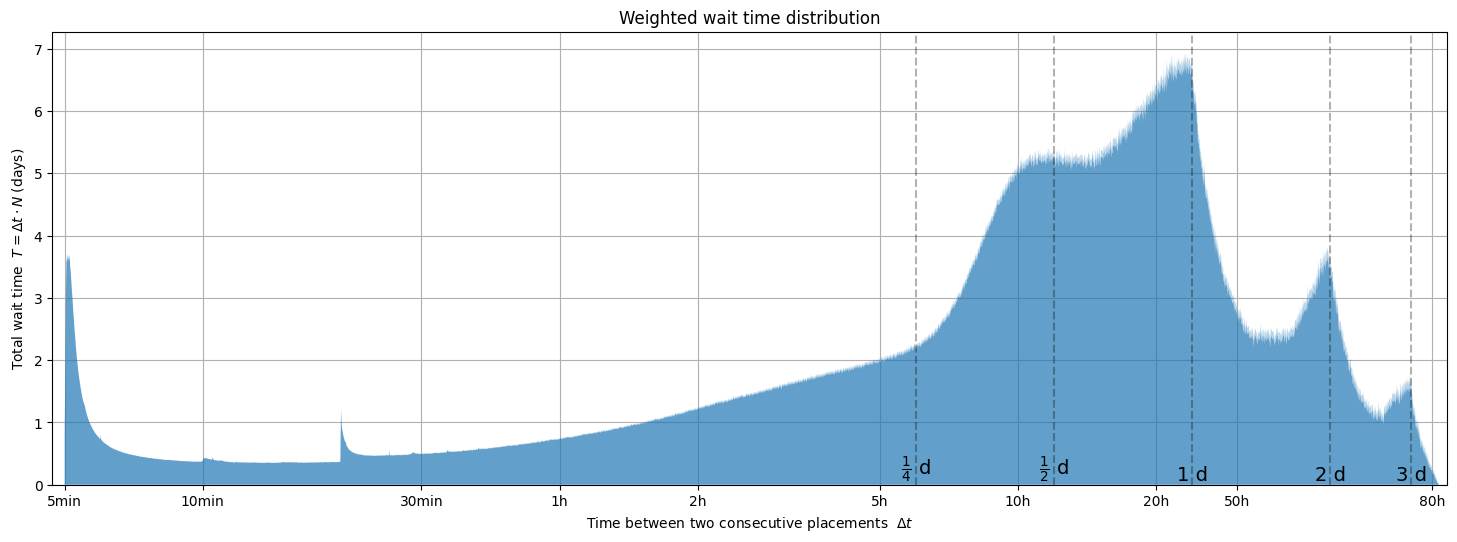

In [13]:
# Plot the weighted histogram as before
fig, ax = plt.subplots(figsize=(18, 6), dpi=100)

# Conversion factor from milliseconds to minutes
factor = 1e3 * 60

# Draw the histogram
ax.fill_between(coarse_hist[1][:-1], 0, weighted_hist/factor/60/24 - weighted_hist_error/factor/60/24, color='tab:blue', alpha=0.7, zorder=2, edgecolor='none')
ax.fill_between(coarse_hist[1][:-1], weighted_hist/factor/60/24 - weighted_hist_error/factor/60/24, weighted_hist/factor/60/24 + weighted_hist_error/factor/60/24, color='tab:blue', alpha=0.3, zorder=2, edgecolor='none')

ax.set_title(f'Weighted wait time distribution')
ax.set_xlabel(r'Time between two consecutive placements  $\Delta t$')
ax.set_ylabel(r'Total wait time  $T = \Delta t \cdot N$ (days)')
# ax.set_yscale('log')

# Create xticks for t = 5min, 10min, 30min, 1h, 2h, 5h, 10h, 20h, 50h, 80h
xticks = np.log([factor * i for i in [5, 10, 30, 60, 120, 300, 600, 1200, 1800, 80*60]])
ax.set_xticks(xticks)

# Create labels for the xticks
xticklabels = ['5min', '10min', '30min', '1h', '2h', '5h', '10h', '20h', '50h', '80h']
ax.set_xticklabels(xticklabels);

ax.set_xlim(xticks[0]*0.995, np.log(83*60*factor)*1.002);
ax.set_ylim(0, None)

ax.axvline(np.log(6*60*factor), color='k', linestyle='--', alpha=0.3)
ax.axvline(np.log(12*60*factor), color='k', linestyle='--', alpha=0.3)
ax.axvline(np.log(24*60*factor), color='k', linestyle='--', alpha=0.3)
ax.axvline(np.log(48*60*factor), color='k', linestyle='--', alpha=0.3)
ax.axvline(np.log(72*60*factor), color='k', linestyle='--', alpha=0.3)

text_location_height = 0

# # Indicate what the lines represent by adding text
ax.text(np.log(6*60*factor), text_location_height, r'$\frac{1}{4}$ d', ha='center', va='bottom', fontsize=14)
ax.text(np.log(12*60*factor), text_location_height, r'$\frac{1}{2}$ d', ha='center', va='bottom', fontsize=14)
ax.text(np.log(24*60*factor), text_location_height, '1 d', ha='center', va='bottom', fontsize=14)
ax.text(np.log(48*60*factor), text_location_height, '2 d', ha='center', va='bottom', fontsize=14)
ax.text(np.log(72*60*factor), text_location_height, '3 d', ha='center', va='bottom', fontsize=14)

ax.grid(axis='both', zorder=1)

In [14]:
'Although there are more active users, most of the time was waited by inactive users.'

'Although there are more active users, most of the time was waited by inactive users.'

### Color specific histograms

In [15]:
# Load the colormap
cmap = pd.read_csv('../maps/color_map.csv')

In [24]:
# Compute the color specific histograms
color_hists = []
for color_index, color_hex in zip(tqdm(cmap['pixel_color_int']), cmap['pixel_color']):
    # Compute the histogram of the wait time distribution of that color
    color_hists.append(np.histogram(
        np.log(valid_wait_times[valid_wait_time_colors == color_index] + 1e-6),
        bins=np.linspace(np.log(5 * 60 * 1e3), np.log(np.max(valid_wait_times)), 512+1)
    ))

100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


100%|██████████| 32/32 [00:00<00:00, 93.86it/s]


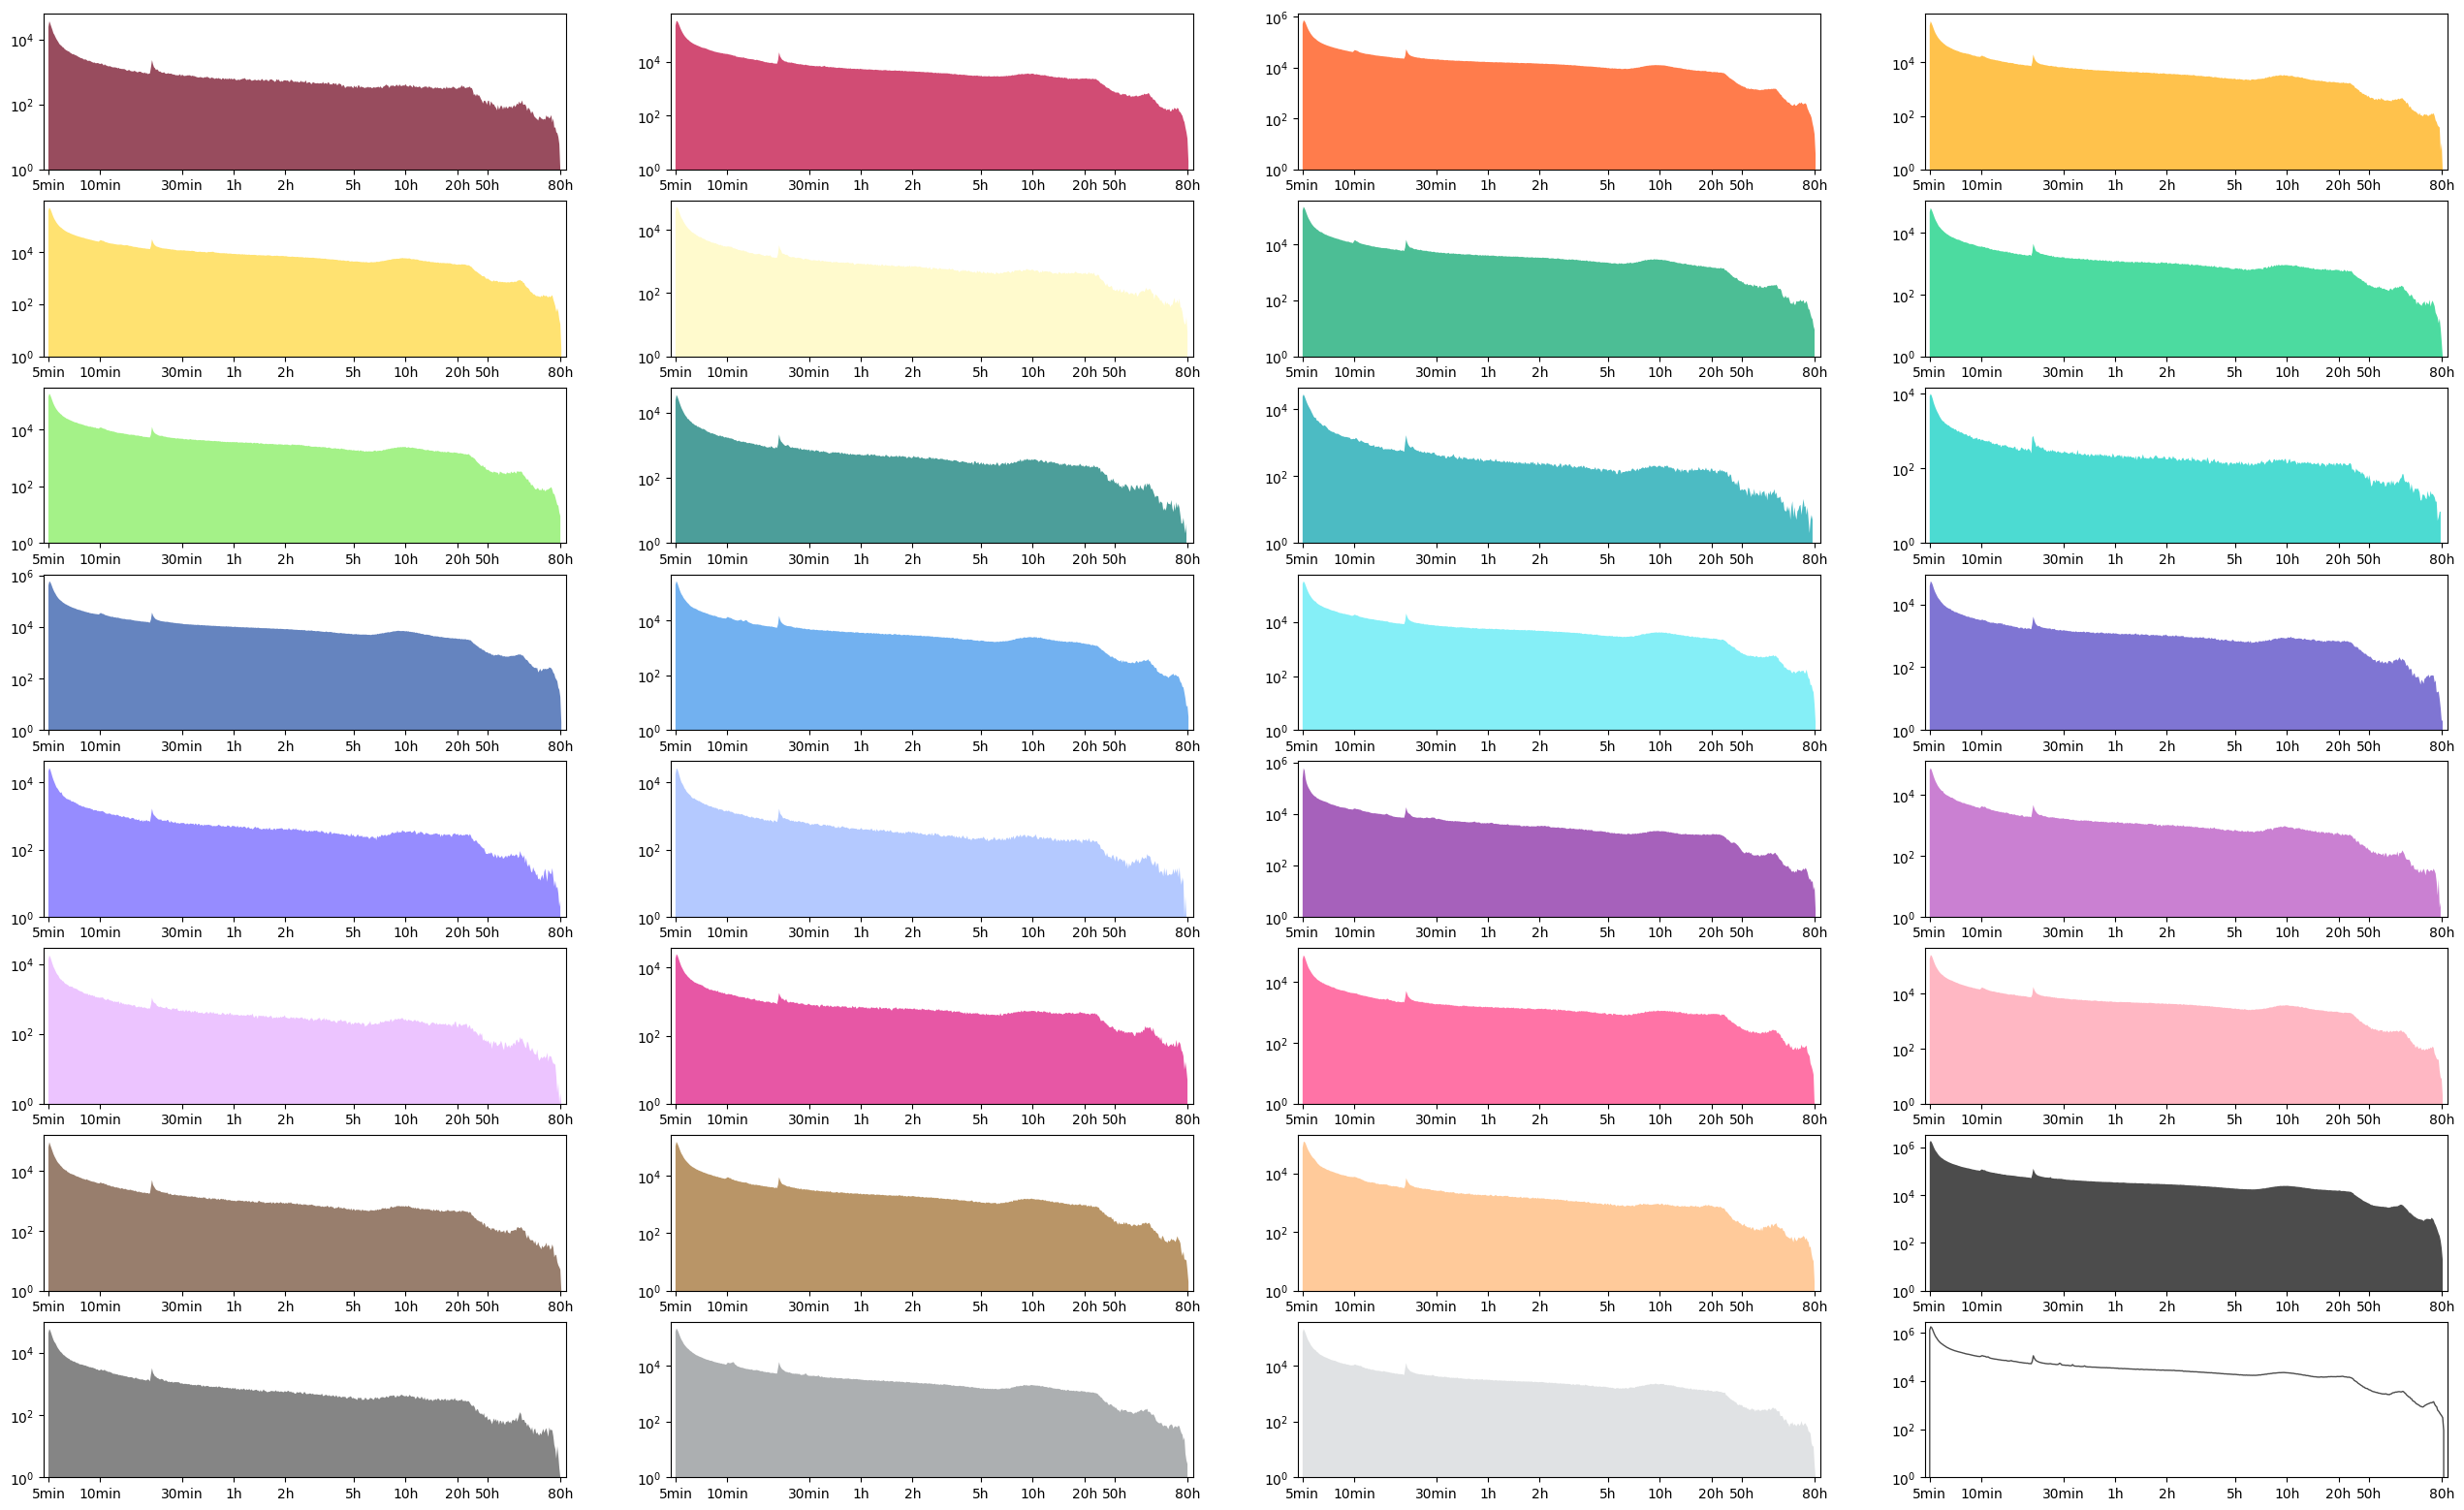

In [33]:
# For each color, plot the histogram of the wait time distribution of that color
fig, axes = plt.subplots(8, 4, figsize=(32, 20), dpi=100)

for color_index, color_hex, color_hist in zip(tqdm(cmap['pixel_color_int']), cmap['pixel_color'], color_hists):
    ax = axes.flatten()[color_index]

    # Draw the histogram
    # If the color is white, outline the histogram with a black line instead of a white fill
    if color_hex == '#FFFFFF':
        ax.fill_between(color_hist[1][:-1], 0, color_hist[0], color=color_hex, alpha=0.7, zorder=2, edgecolor='k')
    else:
        ax.fill_between(color_hist[1][:-1], 0, color_hist[0], color=color_hex, alpha=0.7, zorder=2, edgecolor='none')

    ax.set_yscale('log')

    # Hide the y-axis label
    # ax.set_yticklabels([])

    # Create xticks for t = 5min, 10min, 30min, 1h, 2h, 5h, 10h, 20h, 50h, 80h
    xticks = np.log([factor * i for i in [5, 10, 30, 60, 120, 300, 600, 1200, 1800, 80*60]])
    ax.set_xticks(xticks)

    # Create labels for the xticks
    xticklabels = ['5min', '10min', '30min', '1h', '2h', '5h', '10h', '20h', '50h', '80h']
    ax.set_xticklabels(xticklabels);

    ax.set_xlim(xticks[0]*0.995, np.log(83*60*factor)*1.002);
    ax.set_ylim(1, None)